In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import client_surveillance_jupyter

In [4]:
COMPANY_IDENTIFIER = ['BYN']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [6]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000528-LIC,Retailer,"BYNATE COOPERATIVE, INC.",True,Active,CA-00506,Retailer,c98899d3-3d6c-4bcb-aeb4-30f3e1ee606d,d86c1b4e-c6f7-4e2e-8de4-8ef428dac80c


## Check download status summaries

In [7]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [8]:
license_numbers

array(['C10-0000528-LIC'], dtype=object)

In [9]:
bad_download_history = client_surveillance_jupyter.check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license C10-0000528-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-05-12
Found bad download summary for license C10-0000528-LIC on date 2021-08-03

[FAILURE] Found a total of 1 bad download summaries


In [10]:
bad_download_history

defaultdict(list, {'C10-0000528-LIC': [datetime.date(2021, 8, 3)]})

## Choose license numbers

In [11]:
# get list of retailer license numbers
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())
license_numbers

['C10-0000528-LIC']

# License check

In [12]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000528-LIC,Retailer,"BYNATE COOPERATIVE, INC.",True,Active,CA-00506,Retailer,c98899d3-3d6c-4bcb-aeb4-30f3e1ee606d,d86c1b4e-c6f7-4e2e-8de4-8ef428dac80c


In [13]:
company_state = list(company_licenses_dataframe['us_state'].unique())[0]
company_state

'CA'

In [14]:
retial_license_check_df = company_licenses_dataframe[company_licenses_dataframe['license_number'].isin(license_numbers)][['license_number','license_category','is_current','license_status','us_state']].reset_index(drop = True)
retial_license_check_df['license_check'] = ['YES' if retial_license_check_df['license_status'][i] == 'Active' or str(retial_license_check_df['is_current'][i]) == 'True' else 'NO' for i in range(len(retial_license_check_df))]
retial_license_check_df


,license_number,license_category,is_current,license_status,us_state,license_check
0,C10-0000528-LIC,Retailer,True,Active,CA,YES


## Pull data

In [15]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)

company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [16]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['C10-0000528-LIC'], dtype=object)

In [17]:
company_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000528-LIC'], dtype=object)

In [18]:
company_inventory_packages_dataframe['license_number'].unique()

array(['C10-0000528-LIC'], dtype=object)

## Unknown transfer packages

In [19]:
unknown_package_count = client_surveillance_jupyter.check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[SUCCESS] No unknown transfer packages!


0

## Receiver wholesale price coverage

In [20]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['receiver_wholesale_price'].notnull()].shape

(3813, 32)

In [21]:
company_incoming_transfer_packages_dataframe.shape

(3972, 32)

In [22]:
rwp_coverage = client_surveillance_jupyter.check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


96.0% of incoming transfer packages have receiver wholesale price


## dedupe sales transactions

In [23]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [24]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [25]:
#check we have all locations
deduped_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000528-LIC'], dtype=object)

## Trxns missing incoming transfer packages

In [26]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = client_surveillance_jupyter.check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 25209 (25.41972955803612%)
# transactions total: 99171


In [27]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count


sales_month
2020-12     169
2021-01    2653
2021-02    1836
2021-03    1688
2021-04    1582
2021-05    1256
2021-06    1153
2021-07    1094
2021-08     708
2021-09     843
2021-10     772
2021-11     678
2021-12     680
2022-01     670
2022-02     450
2022-03     595
2022-04     497
2022-05     139
dtype: int64

## Receipts missing metrc_sales_transactions

In [28]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [29]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.01
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 46427


In [30]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

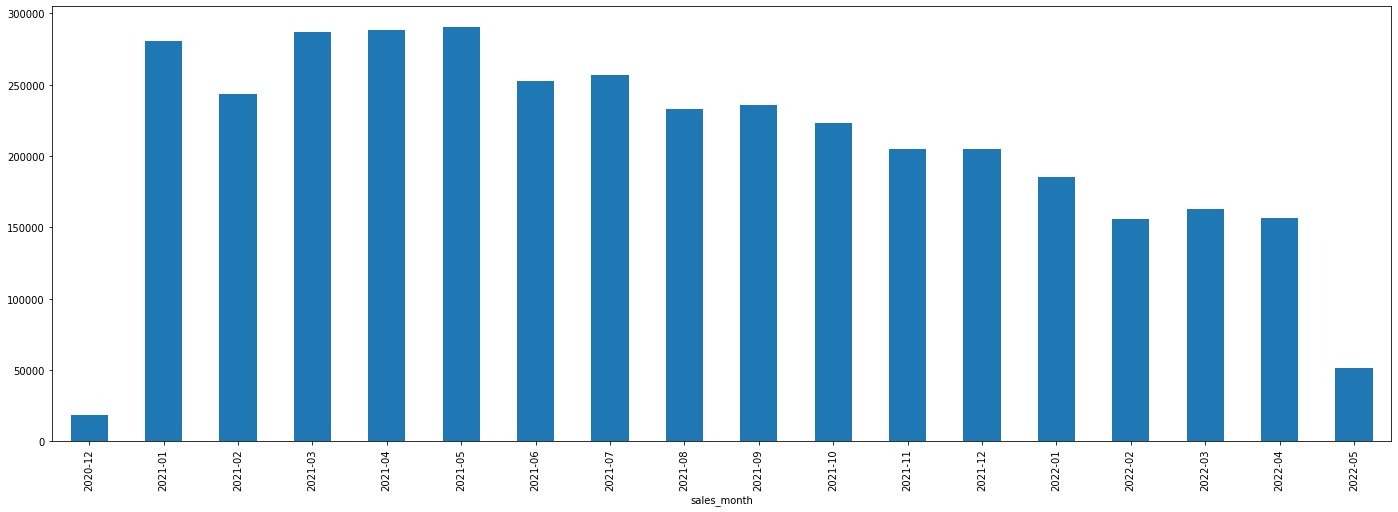

In [31]:
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month'])['tx_total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

# Vendor churn

In [32]:
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-04-01'
VC_MONTH_LIST = ['2022-01-01','2022-02-01','2022-03-01','2022-04-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [33]:
license_numbers

['C10-0000528-LIC']

In [34]:
churn,vc_matrix = client_surveillance_jupyter.calculate_vendor_churn(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST)


In [35]:
churn

,year_month,%_inactive
year_month,,
2020-01-01,2020-01-01,0.000000
2020-02-01,2020-02-01,0.000000
2020-03-01,2020-03-01,0.000000
2020-04-01,2020-04-01,0.000000
2020-05-01,2020-05-01,0.000000
2020-06-01,2020-06-01,0.000000
2020-07-01,2020-07-01,0.000000
2020-08-01,2020-08-01,0.000000
2020-09-01,2020-09-01,1.000000


In [37]:
churn_short,vc_matrix_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)


In [38]:
churn_short

,year_month,%_inactive
year_month,,
2020-01-01,2020-01-01,0.000000
2020-02-01,2020-02-01,0.000000
2020-03-01,2020-03-01,0.000000
2020-04-01,2020-04-01,0.000000
2020-05-01,2020-05-01,0.000000
2020-06-01,2020-06-01,0.000000
2020-07-01,2020-07-01,0.000000
2020-08-01,2020-08-01,0.000000
2020-09-01,2020-09-01,0.000000


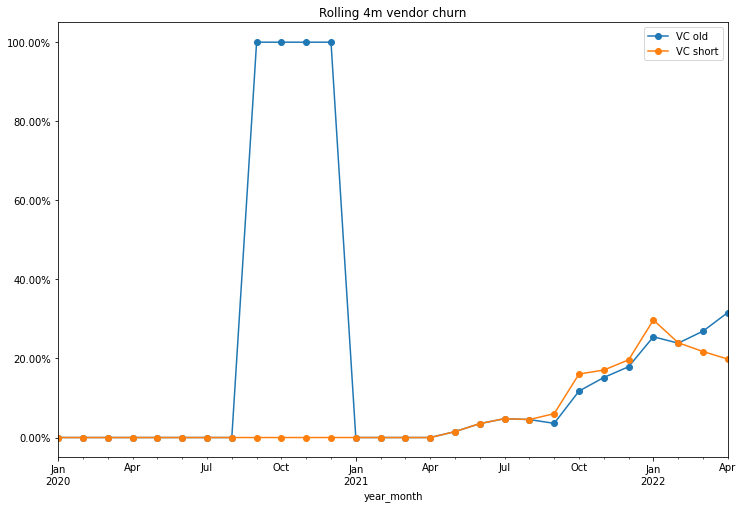

In [39]:
ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC old')
ax = churn_short['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC short')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')
ax = plt.legend()

# Receiver wholesale price outlier check

In [40]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = client_surveillance_jupyter.check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: 160.0 from package ID: 11616157
min per unit incoming: 0.0002 from package ID: 22598944



In [41]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(20)

Top 5 per unit incoming packages


,package_id,per_unit_incoming
0,11616157,160.0
1,12640424,70.0
2,14360017,60.0
3,17441612,60.0
4,16294508,60.0
5,17524120,60.0
6,12678721,60.0
7,11995402,45.0
8,16307956,38.0
9,13637733,38.0


In [42]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


Bottom 5 per unit incoming packages


,package_id,per_unit_incoming
3841,11310206,0.000333
3842,11192434,0.000333
3843,11616116,0.000250
3844,24228175,0.000200
3845,22598944,0.000200


In [43]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] > 10000]

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,receiver_wholesale_price_1,item_unit_weight,item_unit_weight_unit_of_measure_name,per_unit_incoming


# COGS analysis

In [44]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] <= 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [45]:
df_summary_simp,df_cogs_average_product = client_surveillance_jupyter.cogs_analysis(df_in,df_sales,'monthly',company_state)


In [118]:
df_summary_simp

157601.67588235295

# Revenue change vs state

In [47]:
a = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp)
round(a.dropna()['total'].sum(),2)

-2.4

In [48]:
a

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q2,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q3,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q4,0.00,NaN,0.17,0.04,NaN,10,0.4
2021Q1,810965.16,NaN,-0.05,0.28,NaN,10,2.8
2021Q2,831849.95,0.025753,0.02,0.52,0.005753,5,2.6
2021Q3,725203.24,-0.128204,-0.11,0.76,-0.018204,0,0.0
2021Q4,633309.77,-0.126714,0.00,1.00,-0.126714,-5,-5.0


# Inventory

In [140]:
today = date.today()
today

datetime.date(2022, 5, 13)

In [50]:
COMPANY_IDENTIFIER

['BYN']

In [51]:
license_numbers

['C10-0000528-LIC']

In [52]:
df_inventory_license = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory,license_numbers,today)

In [53]:
df_inventory_license

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-05-12,85826.97,109000.25,568,652,0.87,[C10-0000528-LIC],"BYNATE, INC."


In [142]:
min(df_inventory[df_inventory['age_int'] <= 90]['packaged_date'])

datetime.date(2022, 2, 14)

In [ ]:
def calculate_inventory_valuation_fresh(
    incoming_transfer_df, inventory_df, license_list, today_date
):
    # legal name
    legal_name = incoming_transfer_df[
        incoming_transfer_df["license_number"].isin(license_list)
    ]["recipient_facility_name"].values[0]
    # process df_in and df_sales
    incoming_transfer_df["per_unit_incoming"] = (
        incoming_transfer_df["shipper_wholesale_price"]
        / incoming_transfer_df["shipped_quantity"]
    )
    incoming_transfer_df_price = incoming_transfer_df[
        incoming_transfer_df["shipper_wholesale_price"].notnull()
    ]
    # by package id
    average_incoming_package_id = incoming_transfer_df_price.groupby(["package_id"])[
        "per_unit_incoming"
    ].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # by product
    average_incoming_product = incoming_transfer_df_price.groupby(["product_name"])[
        "per_unit_incoming"
    ].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(
        columns={"per_unit_incoming": "per_unit_product"}, inplace=True
    )
    # prepare fresh inventory
    inventory_df['age'] = [today_date - inventory_df['packaged_date'][i] for i in range(len(inventory_df))]
    inventory_df['age_int'] = [inventory_df['age'][i] / np.timedelta64(1, 'D') for i in range(len(inventory_df))]
    inventory_df_fresh = inventory_df[inventory_df['age_int'] <= 90]
    
    # calculate inventory
    df_inventory_incoming = pd.merge(
        inventory_df_fresh,
        df_avg_incoming_price,
        left_on=["package_id"],
        right_on=["package_id"],
        how="left",
    )
    # left_on=['tx_product_name','tx_unit_of_measure'], right_on=['product_name','shipped_unit_of_measure'], how='left'
    df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_null = df_inventory_incoming[
        df_inventory_incoming["per_unit_incoming"].isnull()
    ]
    df_inv_product = pd.merge(
        df_inv_null,
        df_avg_product,
        left_on=["product_name"],
        right_on=["product_name"],
        how="left",
    )
    df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_product_price = df_inv_product[df_inv_product["per_unit_product"].notnull()]
    df_inv_product_price["total_price"] = (
        df_inv_product_price["quantity"] * df_inv_product_price["per_unit_product"]
    )

    inventory_product_value = df_inv_product_price["total_price"].sum()
    df_inventory_incoming["total_price"] = (
        df_inventory_incoming["quantity"] * df_inventory_incoming["per_unit_incoming"]
    )
    inventory_value = df_inventory_incoming["total_price"].sum()
    total_inv_value = inventory_product_value + inventory_value
    total_inv_value_after_tax = (inventory_product_value + inventory_value) * 1.27
    inv_count_product = df_inv_product_price["per_unit_product"].count()
    inv_count_incoming = df_inventory_incoming["per_unit_incoming"].count()
    inv_count_total = df_inventory_incoming["quantity"].count()
    inv_total_incoming = inv_count_product + inv_count_incoming
    inventory_coverage = inv_total_incoming / inv_count_total
    # prepare data
    data = [
        [today_date],
        [round(total_inv_value,2)],
        [round(total_inv_value_after_tax,2)],
        [inv_total_incoming],
        [inv_count_total],
        [round(inventory_coverage,2)],
        [license_list],
        [legal_name],
    ]
    df_inventory_license = pd.DataFrame(data).T
    df_inventory_license.columns = [
        "date",
        "value",
        "value_after_tax",
        "total_incoming",
        "total",
        "coverage",
        "license",
        "legal_name",
    ]
    return df_inventory_license

In [82]:
df_inventory_license_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales,df_inventory,license_numbers,today)

In [83]:
df_inventory_license_msrp

,date,value,total_incoming,total,coverage,license,legal_name
0,2022-05-12,319541.12,600,652,0.92,[C10-0000528-LIC],"BYNATE, INC."


In [134]:
df_inventory_license_fresh = client_surveillance_jupyter.calculate_inventory_valuation_fresh(df_in,df_inventory,license_numbers,today)




In [135]:
df_inventory_license_fresh

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-05-12,65231.62,82844.16,366,406,0.9,[C10-0000528-LIC],"BYNATE, INC."


In [117]:
current_month = '2022-04'
full_score = 45

# Create Template: updated

In [120]:
license_numbers

['C10-0000528-LIC']

In [148]:
template_new_ = client_surveillance_jupyter.create_template_update(a,df_summary_simp,df_inventory_license,df_inventory_license_msrp,churn_short,retial_license_check_df,license_numbers,company_state,current_month)



0.8258823529411764 True
0.87 True
6.5072878606806235 10
0.19829897562570828 10


In [149]:
template_new_

,0,1
0,legal name,"BYNATE, INC."
1,date,2022-04
2,license,[C10-0000528-LIC]
3,license is current,True
4,license is active,Active
5,license check,YES
6,metrc cogs coverage,0.825882
7,metrc cogs coverage reliable ?,True
8,metrc inventory coverage,0.87
9,metrc inventory coverage reliable ?,True


In [ ]:
today

In [ ]:
company_inventory_packages_dataframe['diff'] = [today - company_inventory_packages_dataframe['packaged_date'][i] for i in range(len(company_inventory_packages_dataframe))]




In [ ]:
company_inventory_packages_dataframe['diff']

In [ ]:
company_inventory_packages_dataframe['diff_int'] = [company_inventory_packages_dataframe['diff'][i] / np.timedelta64(1, 'D') for i in range(len(company_inventory_packages_dataframe))]

In [ ]:
company_inventory_packages_dataframe[['product_category_name','diff_int']].groupby(['product_category_name']).describe()

# Output data 

In [ ]:
license_numbers

## others

In [ ]:
# for only 1 license
license_number = license_numbers[0]
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')
#retial_license_check_df



# Appendix

In [ ]:
# def calculate_quarterly_sum_gmv_ma_short(cogs_analysis_df):

#     gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-09')&(cogs_analysis_df['date'] <= '2022-02')][['revenue_change']]
#     gmv_df['sum_gmv_change_ma'] = [-0.07,0.09,-0.11,0.02]
#     gmv_df['weight'] = [0.76,0.84,0.92,1]
#     gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_ma']
#     gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
#     gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
#     gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
#     return gmv_df
    